In [1]:
!pip install kaggle

In [0]:
!mkdir .kaggle

In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c quora-insincere-questions-classification

 75% 41.0M/54.4M [00:00<00:00, 46.0MB/s]
100% 54.4M/54.4M [00:00<00:00, 74.5MB/s]
100% 5.95G/5.96G [00:52<00:00, 87.1MB/s]
100% 5.96G/5.96G [00:52<00:00, 121MB/s] 
  0% 0.00/4.08M [00:00<?, ?B/s]
100% 4.08M/4.08M [00:00<00:00, 37.5MB/s]
 38% 6.00M/15.7M [00:00<00:00, 62.7MB/s]
100% 15.7M/15.7M [00:00<00:00, 99.5MB/s]


In [10]:
!unzip /content/{/content}/competitions/quora-insincere-questions-classification/test.csv.zip

Archive:  /content/{/content}/competitions/quora-insincere-questions-classification/test.csv.zip
  inflating: test.csv                


In [12]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [13]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


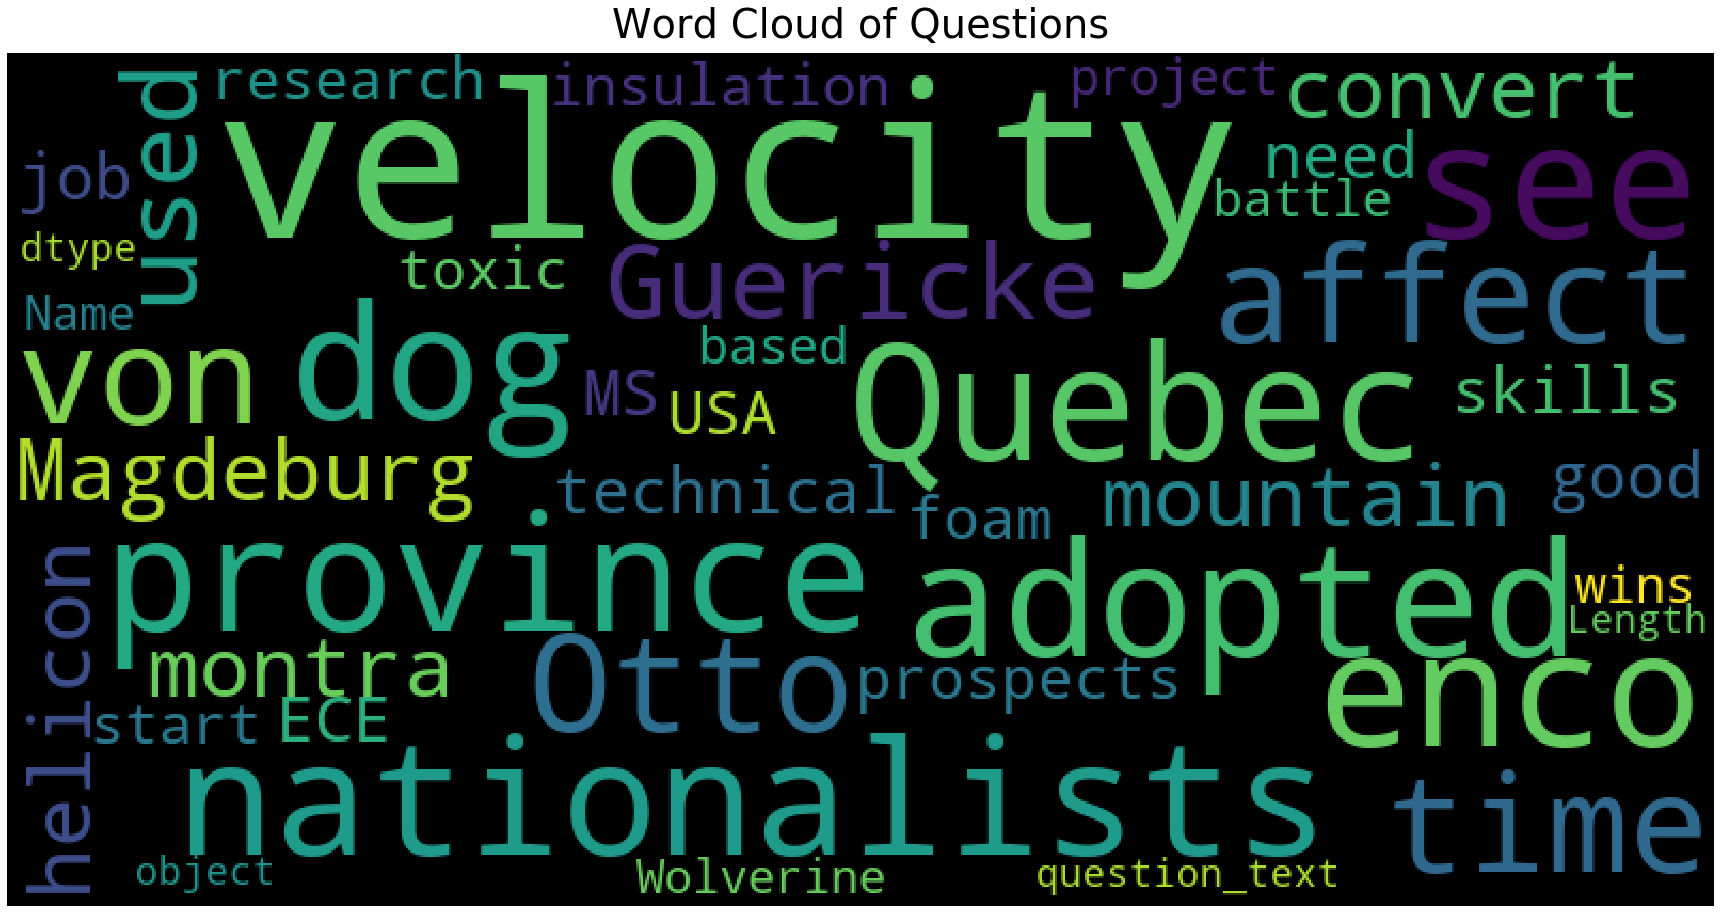

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["question_text"], title="Word Cloud of Questions")


In [17]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

In [19]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
__________________________________________

In [20]:
## Train the model 
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))





Train on 1175509 samples, validate on 130613 samples
Epoch 1/2





1175509/1175509 [==============================] - 237s 202us/step - loss: 0.1209 - acc: 0.9536 - val_loss: 0.1105 - val_acc: 0.9547
Epoch 2/2
1175509/1175509 [==============================] - 231s 197us/step - loss: 0.0975 - acc: 0.9610 - val_loss: 0.1068 - val_acc: 0.9573


In [21]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))

130613/130613 [==============================] - 6s 46us/step
F1 score at threshold 0.1 is 0.5850892080970319
F1 score at threshold 0.11 is 0.5928336009465055
F1 score at threshold 0.12 is 0.6008273009307136
F1 score at threshold 0.13 is 0.6079094061361541
F1 score at threshold 0.14 is 0.6126744860188199
F1 score at threshold 0.15 is 0.6181620248571169
F1 score at threshold 0.16 is 0.6220646468367252
F1 score at threshold 0.17 is 0.626232419045839
F1 score at threshold 0.18 is 0.6299749183663811
F1 score at threshold 0.19 is 0.6334052240594297
F1 score at threshold 0.2 is 0.6366902981450908
F1 score at threshold 0.21 is 0.6387676004513565
F1 score at threshold 0.22 is 0.6406909217253188
F1 score at threshold 0.23 is 0.6421907914535059
F1 score at threshold 0.24 is 0.6446767481985182
F1 score at threshold 0.25 is 0.6468382390712487
F1 score at threshold 0.26 is 0.6487440315549097
F1 score at threshold 0.27 is 0.650261780104712
F1 score at threshold 0.28 is 0.6514582120362039
F1 score at

In [22]:
pred_noemb_test_y = model.predict([test_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 17s 45us/step


In [0]:
del model, inp, x
import gc; gc.collect()
time.sleep(10)

In [24]:
#Glove Embeddings
EMBEDDING_FILE = 'glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17  

In [25]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 235s 200us/step - loss: 0.1162 - acc: 0.9537 - val_loss: 0.1012 - val_acc: 0.9595
Epoch 2/2
1175509/1175509 [==============================] - 234s 199us/step - loss: 0.0941 - acc: 0.9616 - val_loss: 0.0997 - val_acc: 0.9594


In [26]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))

130613/130613 [==============================] - 6s 47us/step
F1 score at threshold 0.1 is 0.5958456002616944
F1 score at threshold 0.11 is 0.6042031523642732
F1 score at threshold 0.12 is 0.6118166758696852
F1 score at threshold 0.13 is 0.6188666205943331
F1 score at threshold 0.14 is 0.6234586862082584
F1 score at threshold 0.15 is 0.6284391416614727
F1 score at threshold 0.16 is 0.6326189939093165
F1 score at threshold 0.17 is 0.6375182748538011
F1 score at threshold 0.18 is 0.6402258422806368
F1 score at threshold 0.19 is 0.6433455090381193
F1 score at threshold 0.2 is 0.6481894547007735
F1 score at threshold 0.21 is 0.651354591225126
F1 score at threshold 0.22 is 0.6548363636363637
F1 score at threshold 0.23 is 0.6571316614420063
F1 score at threshold 0.24 is 0.6594134810345681
F1 score at threshold 0.25 is 0.6625049940071912
F1 score at threshold 0.26 is 0.6634450820497332
F1 score at threshold 0.27 is 0.6653113087674714
F1 score at threshold 0.28 is 0.6683772965205789
F1 score a

In [27]:
pred_glove_test_y = model.predict([test_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 17s 46us/step


In [0]:
del word_index, embeddings_index, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

In [29]:
EMBEDDING_FILE = 'wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [30]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 233s 198us/step - loss: 0.1164 - acc: 0.9547 - val_loss: 0.1035 - val_acc: 0.9591
Epoch 2/2
1175509/1175509 [==============================] - 232s 198us/step - loss: 0.0933 - acc: 0.9626 - val_loss: 0.1025 - val_acc: 0.9598


In [31]:
pred_fasttext_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_fasttext_val_y>thresh).astype(int))))

130613/130613 [==============================] - 6s 46us/step
F1 score at threshold 0.1 is 0.6061982939688799
F1 score at threshold 0.11 is 0.6134207650273225
F1 score at threshold 0.12 is 0.6211235553969033
F1 score at threshold 0.13 is 0.6273190251000365
F1 score at threshold 0.14 is 0.6329160700263291
F1 score at threshold 0.15 is 0.6378550670291552
F1 score at threshold 0.16 is 0.642334378861325
F1 score at threshold 0.17 is 0.6466615206483983
F1 score at threshold 0.18 is 0.650424763206718
F1 score at threshold 0.19 is 0.6527709177121407
F1 score at threshold 0.2 is 0.6565924443332499
F1 score at threshold 0.21 is 0.6584624734123367
F1 score at threshold 0.22 is 0.6601444450135736
F1 score at threshold 0.23 is 0.6615551986737812
F1 score at threshold 0.24 is 0.66377008846778
F1 score at threshold 0.25 is 0.6651854203036555
F1 score at threshold 0.26 is 0.6676643506146447
F1 score at threshold 0.27 is 0.6689737212068778
F1 score at threshold 0.28 is 0.6684121529482354
F1 score at t

In [32]:
pred_fasttext_test_y = model.predict([test_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 17s 45us/step


In [0]:
del word_index, embeddings_index, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

In [34]:
EMBEDDING_FILE = 'paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [35]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 231s 197us/step - loss: 0.1150 - acc: 0.9556 - val_loss: 0.1026 - val_acc: 0.9582
Epoch 2/2
1175509/1175509 [==============================] - 229s 195us/step - loss: 0.0950 - acc: 0.9623 - val_loss: 0.1005 - val_acc: 0.9599


In [36]:
pred_paragram_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_paragram_val_y>thresh).astype(int))))

130613/130613 [==============================] - 6s 47us/step
F1 score at threshold 0.1 is 0.6004276191674004
F1 score at threshold 0.11 is 0.6099467445456107
F1 score at threshold 0.12 is 0.6186444395700812
F1 score at threshold 0.13 is 0.6272666218938885
F1 score at threshold 0.14 is 0.6330869604890957
F1 score at threshold 0.15 is 0.638313678150246
F1 score at threshold 0.16 is 0.6432445178024051
F1 score at threshold 0.17 is 0.6476081022841546
F1 score at threshold 0.18 is 0.652315467223869
F1 score at threshold 0.19 is 0.6563763684781536
F1 score at threshold 0.2 is 0.6602349412646839
F1 score at threshold 0.21 is 0.6618719611021069
F1 score at threshold 0.22 is 0.66434319102045
F1 score at threshold 0.23 is 0.6659757487822572
F1 score at threshold 0.24 is 0.6675739335252552
F1 score at threshold 0.25 is 0.6700163960437934
F1 score at threshold 0.26 is 0.6715429791777895
F1 score at threshold 0.27 is 0.6723459319566507
F1 score at threshold 0.28 is 0.6727985196473277
F1 score at t

In [37]:
pred_paragram_test_y = model.predict([test_X], batch_size=1024, verbose=1)

375806/375806 [==============================] - 17s 45us/step


In [0]:
del word_index, embeddings_index, all_embs, embedding_matrix, model, inp, x
import gc; gc.collect()
time.sleep(10)

In [39]:
#Blending
pred_val_y = 0.33*pred_glove_val_y + 0.33*pred_fasttext_val_y + 0.34*pred_paragram_val_y 
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))


F1 score at threshold 0.1 is 0.6019602166990613
F1 score at threshold 0.11 is 0.6113252297657872
F1 score at threshold 0.12 is 0.619523377016565
F1 score at threshold 0.13 is 0.6263489406686341
F1 score at threshold 0.14 is 0.6335648666816043
F1 score at threshold 0.15 is 0.6397192854538826
F1 score at threshold 0.16 is 0.6447551152671049
F1 score at threshold 0.17 is 0.6497036967359608
F1 score at threshold 0.18 is 0.6546113841309223
F1 score at threshold 0.19 is 0.6578108395324123
F1 score at threshold 0.2 is 0.6621006800058705
F1 score at threshold 0.21 is 0.6650838403323934
F1 score at threshold 0.22 is 0.6680661768381067
F1 score at threshold 0.23 is 0.6713145397595232
F1 score at threshold 0.24 is 0.6733006736068585
F1 score at threshold 0.25 is 0.6742674370614941
F1 score at threshold 0.26 is 0.6770529387244686
F1 score at threshold 0.27 is 0.6789135698494578
F1 score at threshold 0.28 is 0.6802960123515945
F1 score at threshold 0.29 is 0.680359159094575
F1 score at threshold 0.